# Time Series Regression using Jena weather dataset to predict temperature

In [1]:
# # Download the dataset
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

### Data Exploration

In [2]:
import os
import pandas as pd

fname = os.path.join("jena_climate_2009_2016.csv")

df = pd.read_csv(fname, index_col="Date Time", nrows=20000) # why Date Time is skipped
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


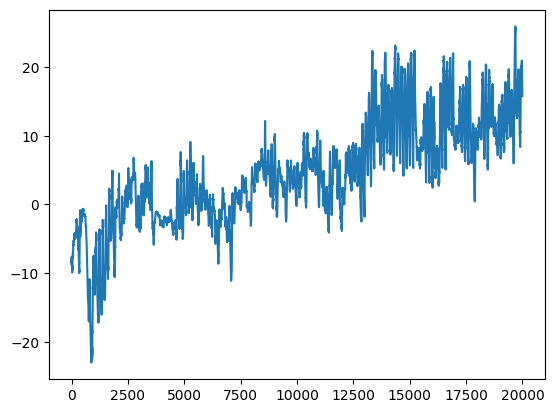

In [3]:
# Plotting temperature
import matplotlib.pyplot as plt

temperature = df["T (degC)"]
plt.plot(range(len(df)), temperature) # there' some clear pattern when run on the full data


### Split the data
-- keep in mind that data must be split in the sequential order (first training, later for validation then for the test)


In [4]:
num_train_samples = int(0.5 * len(df))
num_val_samples = int(0.25 * len(df))
num_test_samples = int(0.25 * len(df))

In [5]:
# Normalizing the data
raw_data = df.copy()
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

### Validation, Training and Testing datasets using `timeseries_dataset_from_array()`
sampling_rate = 6 - Observations will be sampled at one data point per hour<br>
sequence_length = 120 - Observations will go back 5 days<br>
delay = sampling_rate * (sequence_length + 24 - 1) - The target for a sequence will be the temperature 24 hours after the end of the sequence  <br>

In [6]:
import keras

sampling_rate = 6
sequence_length = 120 
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
)

2024-07-15 20:06:02.421301: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 20:06:02.422431: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 20:06:02.426085: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 20:06:02.435570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 20:06:02.452992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [7]:
for samples, targets in train_dataset.take(1):
    print(f"samples shape: {samples.shape}")
    print(f"targets shape: {targets.shape}")


samples shape: (256, 120, 14)
targets shape: (256,)


2024-07-15 20:06:04.376116: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Recurrent Neural Networks
SimpleRNN: <br>
&emsp; state_t = activation(dot(input_t, W) + dot(state_t, U) + b)<br>
&emsp; output can be a sequence of states or the final state<br>

LSTM: <br>
&emsp; state_t = activation(dot(input_t, W) + dot(state_t, U) + dot(carry_t, V) + b)<br>
&emsp; carry_t = activation(dot(input_t, W) + dot(state_t, U) + b)<br>


`Recurrent Dropout` - the variant of Dropout <b style="display:none">Remember how Hinton came up with it?</b> to fight overfitting<br>
`Stacking recurrent layers` - increase the representational power of the model (similar to stacking conv layers), more computationaly expensive though<br>
`Bidirectional recurrent layers` - increases accuracy and mitigates forgetting issues by introducing the same information in different ways<br>

In [23]:
# LSTM with Dropout
import keras 
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 17.3594 - mae: 3.0574 - val_loss: 85.4344 - val_mae: 7.3379
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 12.6208 - mae: 2.6548 - val_loss: 79.6097 - val_mae: 7.0251
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 10.8165 - mae: 2.4906 - val_loss: 72.3994 - val_mae: 6.6591
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 9.3110 - mae: 2.2964 - val_loss: 64.8032 - val_mae: 6.2898
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 8.6197 - mae: 2.1981 - val_loss: 58.0836 - val_mae: 6.0095
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 7.9028 - mae: 2.0994 - val_loss: 53.8155 - val_mae: 5.8397
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 7.3590 - mae: 2.0123 - val_loss: 50.0284 - val_mae: 5.6511
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 6.8732 - mae: 1.9721 - val_loss: 46.5336 - val_mae: 5.4765
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 123m

In [20]:
# A deeper model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.2)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks
)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 296ms/step - loss: 925493571715334144.0000 - mae: 215206448.0000 - val_loss: 109.3933 - val_mae: 8.5531
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - loss: 24243812633149440.0000 - mae: 20105476.0000 - val_loss: 110.8589 - val_mae: 8.6123
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - loss: 1001431217733632.0000 - mae: 3176915.2500 - val_loss: 112.2979 - val_mae: 8.6725
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 152237665943552.0000 - mae: 711871.1250 - val_loss: 113.2256 - val_mae: 8.7137
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - loss: 3916011405312.0000 - mae: 90358.5625 - val_loss: 113.0234 - val_mae: 8.7057
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - loss: 1743529050112.0000 - mae: 46012.1523 - val_loss: 113.3323 - val_mae: 8.7140
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 1429659320320.0000 - mae: 33134.7031 - val_loss: 113.5479 - val_mae: 8.7211
Epoch 8/20
37/37 ━━

In [22]:
# Bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data = val_dataset
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 18.2198 - mae: 3.1264 - val_loss: 84.8493 - val_mae: 7.3310
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 13.0503 - mae: 2.6464 - val_loss: 76.8570 - val_mae: 6.8753
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 9.4592 - mae: 2.2379 - val_loss: 71.4961 - val_mae: 6.5819
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 7.3475 - mae: 1.9482 - val_loss: 67.1789 - val_mae: 6.4330
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 5.8861 - mae: 1.7077 - val_loss: 62.4300 - val_mae: 6.1921
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 4.9105 - mae: 1.5564 - val_loss: 59.1963 - val_mae: 6.0479
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 4.5045 - mae: 1.4645 - val_loss: 55.7866 - val_mae: 5.8657
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 3.9774 - mae: 1.3828 - val_loss: 52.7528 - val_mae: 5.6862
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms